In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import collections

import librosa
import soundfile as sf

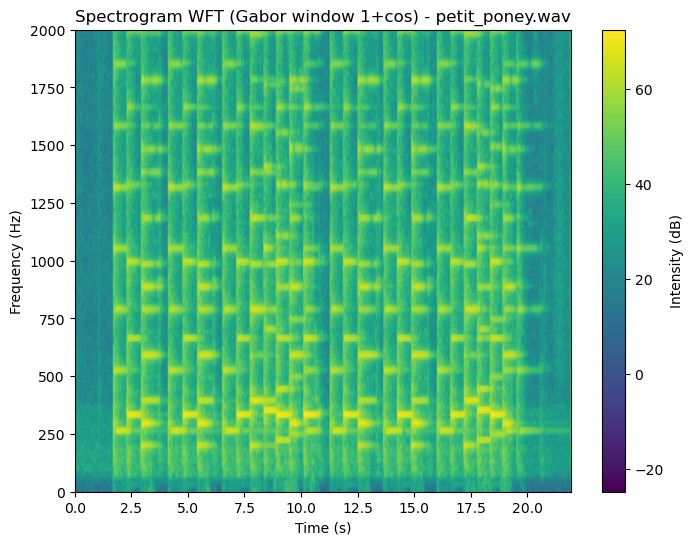

In [34]:
def gabor_wft(signal, fs, window_size, step_size):
    """
    Implementation of WFT using a window of 1 + cos(u).
    """
    u = np.linspace(-np.pi, np.pi, window_size)
    window = 1 + np.cos(u) # Define window form -pi to pi
    
    # Define spectrogram
    num_frames = (len(signal) - window_size) // step_size
    frequencies = np.fft.rfftfreq(window_size, 1/fs)
    spectrogram = np.zeros((len(frequencies), num_frames))

    # Apply the sliding window
    for i in range(num_frames):
        start = i*step_size
        end = start + window_size
        segment = signal[start:end]*window
        
        # FFT
        fft_result = np.fft.rfft(segment)
        spectrogram[:, i] = np.abs(fft_result)
        
    return frequencies, spectrogram

# Load audio
fs, data = wavfile.read('Audios/petit_poney.wav')
if len(data.shape) > 1:
    data = data[:, 0]

# Parameters: Window Size and Step Size
win_size = int(0.1 * fs) 
step = win_size // 50

freqs, spec = gabor_wft(data, fs, win_size, step) # Applying WFT

# Visualization 
plt.figure(figsize=(8, 6))
plt.imshow(10 * np.log10(spec + 1e-10), aspect='auto', origin='lower', extent=[0, len(data)/fs, 0, fs/2])
plt.colorbar(label='Intensity (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spectrogram WFT (Gabor window 1+cos) - petit_poney.wav')
plt.ylim(0, 2000)
#plt.xlim(5, 10.0)
#plt.savefig('spec_chopin')
plt.show()

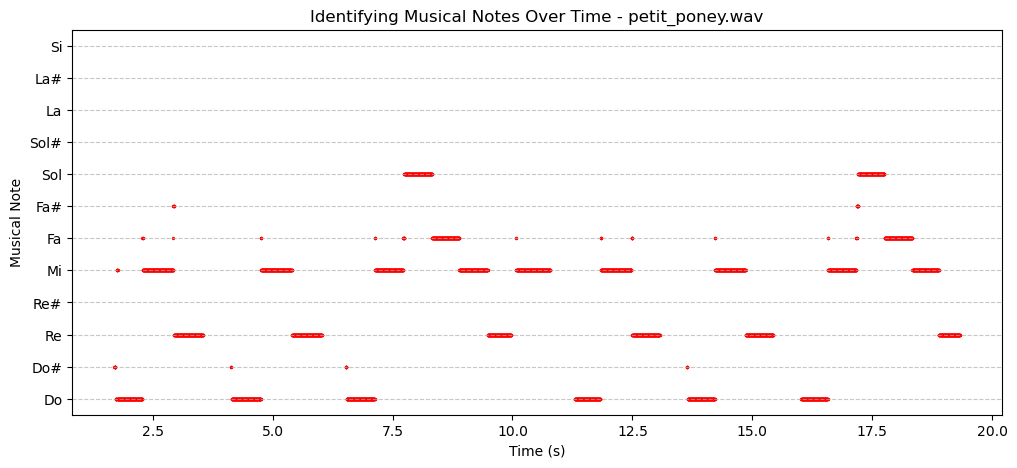

In [35]:
def freq_to_note(f):
    if f <= 0: return None
    # Define notes
    notes = ['La', 'La#', 'Si', 'Do', 'Do#', 'Re', 'Re#', 'Mi', 'Fa', 'Fa#', 'Sol', 'Sol#']
    # Frequency to semitones (reference is La on 440Hz)
    n = 12*np.log2(f / 440.0)
    return notes[int(round(n)) % 12]

# Extraction of the fundamental frequency in each frame
ind_max = np.argmax(spec, axis=0) # Look for the maximum value in each frame
f0 = freqs[ind_max] # Fundamental frequency

# Convert frequencies to notes
notes = []
time = np.linspace(0, len(data)/fs, len(f0))

# Threshold to detect silence
threshold = np.max(spec) * 0.1 

for i in range(len(f0)):
    if np.max(spec[:, i]) > threshold:
        notes.append(freq_to_note(f0[i]))
    else:
        notes.append("Silence")

# Preparing graph for the notes evolution
notes_scale = ['Do', 'Do#', 'Re', 'Re#', 'Mi', 'Fa', 'Fa#', 'Sol', 'Sol#', 'La', 'La#', 'Si']
dict_notes = {note: i for i, note in enumerate(notes_scale)}
y_values = [dict_notes[n] if n in dict_notes else None for n in notes]

# Visualization
plt.figure(figsize=(12, 5))
plt.scatter(time, y_values, s=2, color='red')

plt.yticks(range(12), notes_scale)
plt.ylim(-0.5, 11.5)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.xlabel('Time (s)')
plt.ylabel('Musical Note')
plt.title('Identifying Musical Notes Over Time - petit_poney.wav')
plt.savefig('notes_poney')
plt.show()


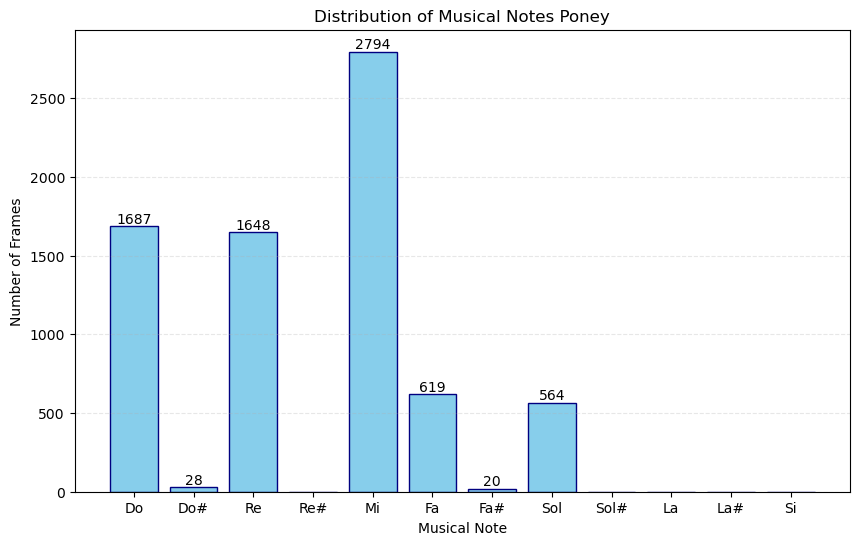

In [36]:
real_notes = [n for n in notes if n != "Silence"]

notes_counting = collections.Counter(real_notes)

counts = [notes_counting.get(nota, 0) for nota in notes_scale]

plt.figure(figsize=(10, 6))
bars = plt.bar(notes_scale, counts, color='skyblue', edgecolor='navy')

# Labels over each bar
for bar in bars:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.xlabel('Musical Note')
plt.ylabel('Number of Frames')
plt.title('Distribution of Musical Notes Poney')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.savefig('hist_poney')
plt.show()


### Voice Identifaction

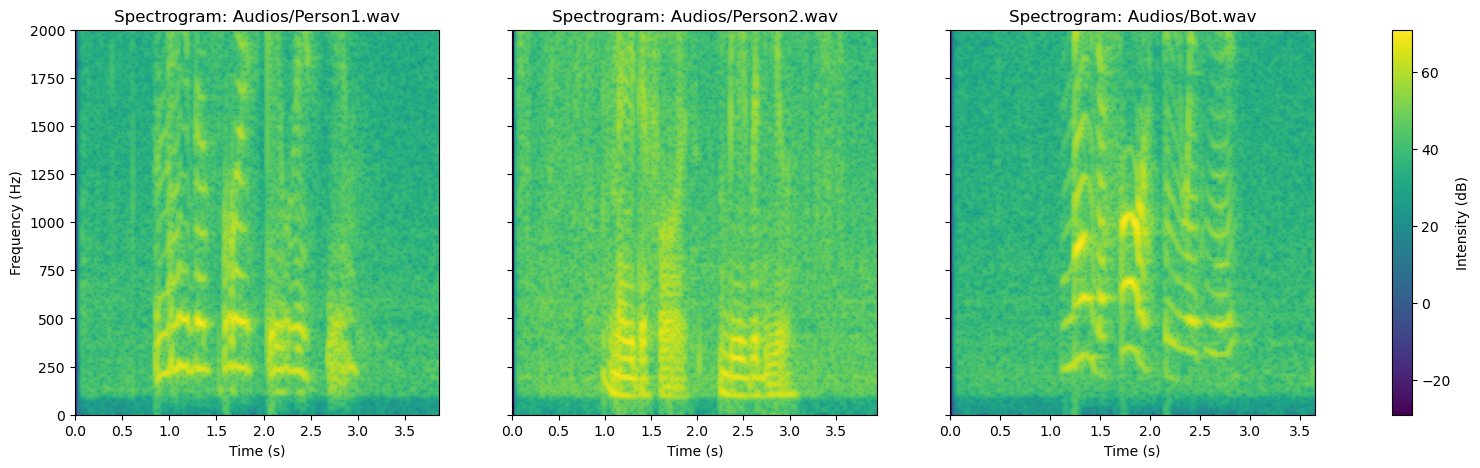

In [45]:
def gabor_wft(signal, fs, window_size, step_size):
    """
    Implementation of WFT using a window of 1 + cos(u).
    """
    u = np.linspace(-np.pi, np.pi, window_size)
    window = 1 + np.cos(u) # Define window form -pi to pi
    
    # Define spectrogram
    num_frames = (len(signal) - window_size) // step_size
    frequencies = np.fft.rfftfreq(window_size, 1/fs)
    spectrogram = np.zeros((len(frequencies), num_frames))

    # Apply the sliding window
    for i in range(num_frames):
        start = i*step_size
        end = start + window_size
        segment = signal[start:end]*window
        
        # FFT
        fft_result = np.fft.rfft(segment)
        spectrogram[:, i] = np.abs(fft_result)
        
    return frequencies, spectrogram

files = ['Audios/Person1.wav', 'Audios/Person2.wav', 'Audios/Bot.wav']
spectrogram = []

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for i, nombre_archivo in enumerate(files):

    fs, data = wavfile.read(nombre_archivo)
    if len(data.shape) > 1:
        data = data[:, 0]
    
    win_size = int(0.1 * fs)
    step = win_size // 50
    freqs, spec = gabor_wft(data, fs, win_size, step)
    
    spec_db = 10 * np.log10(spec + 1e-10)
    spectrogram.append(spec)

    
    im = axes[i].imshow(spec_db, aspect='auto', origin='lower', extent=[0, len(data)/fs, 0, fs/2], vmin=np.max(spec_db)-100, vmax=np.max(spec_db))
    
    axes[i].set_title(f'Spectrogram: {nombre_archivo}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylim(0, 2000)

axes[0].set_ylabel('Frequency (Hz)')
fig.colorbar(im, ax=axes.ravel().tolist(), label='Intensity (dB)')
plt.savefig('voice_spectrograms_combined')
plt.show()


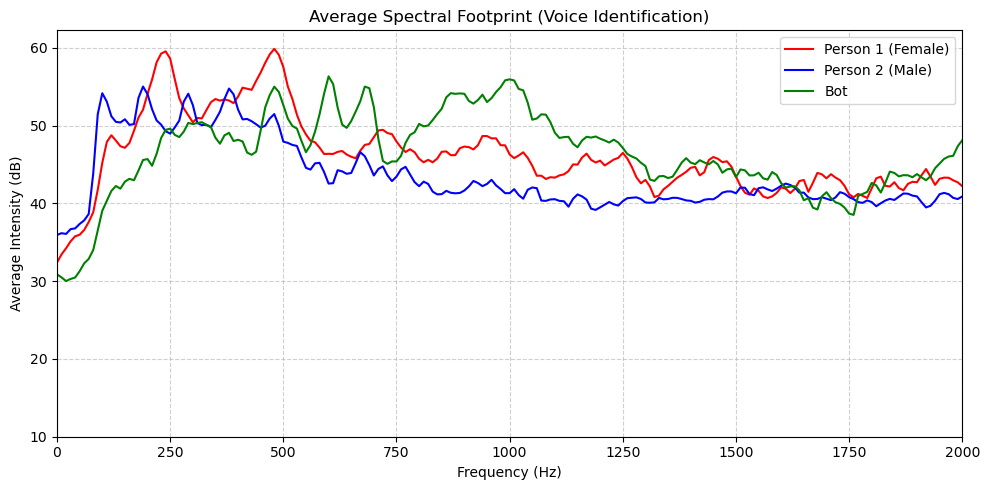

In [48]:
spec_mean_db = []
for i, nombre_archivo in enumerate(files):

    spec_mean = np.mean(spectrogram[i], axis=1)
    spec_mean_db.append(10 * np.log10(spec_mean + 1e-10))


plt.figure(figsize=(10, 5))
plt.plot(freqs, spec_mean_db[0], color='red', linewidth=1.5, label = 'Person 1 (Female)')
plt.plot(freqs, spec_mean_db[1], color='blue', linewidth=1.5, label = 'Person 2 (Male)')
plt.plot(freqs, spec_mean_db[2], color='green', linewidth=1.5, label = 'Bot')

plt.title('Average Spectral Footprint (Voice Identification)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Intensity (dB)')

plt.xlim(0, 2000) 
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.savefig('spectral_footprint')
plt.show()

### Change voice

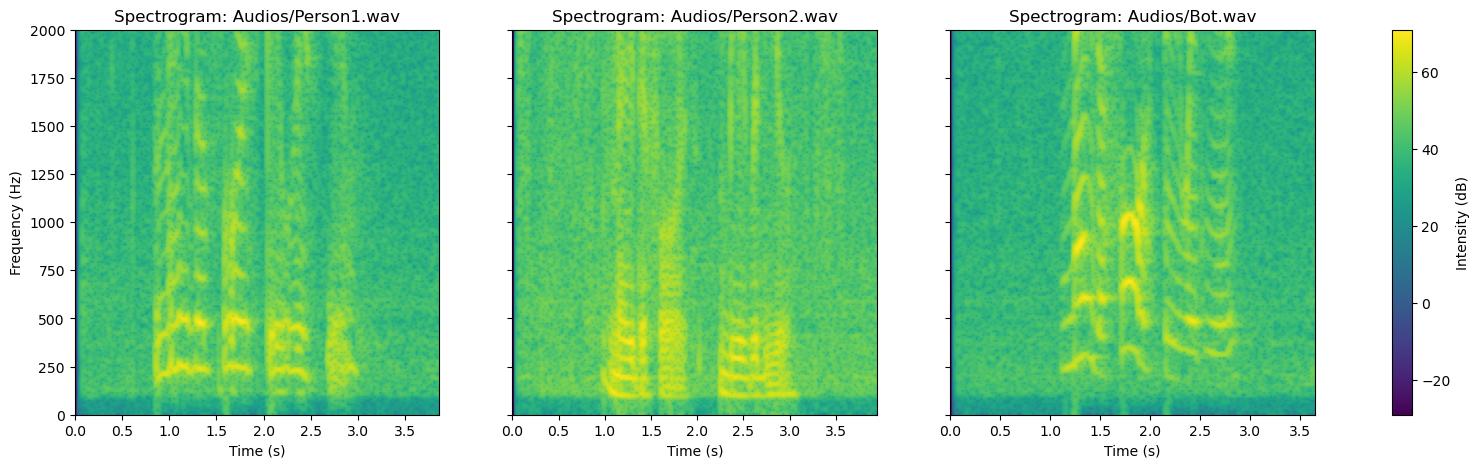

In [49]:
def gabor_wft_complex(signal, fs, window_size, step_size):
    """
    Implementation of WFT using a window of 1 + cos(u). Taking into account complex part
    """
    u = np.linspace(-np.pi, np.pi, window_size)
    window = 1 + np.cos(u)
    
    num_frames = (len(signal) - window_size) // step_size
    frequencies = np.fft.fftfreq(window_size, 1/fs)
    spectrogram_complex = np.zeros((window_size, num_frames), dtype=complex)

    for i in range(num_frames):
        start = i*step_size
        end = start + window_size
        segment = signal[start:end]*window
        
        spectrogram_complex[:, i] = np.fft.fft(segment)
        
    return frequencies, spectrogram_complex

files = ['Audios/Person1.wav', 'Audios/Person2.wav', 'Audios/Bot.wav']
spectrograms_complex = [] 
fs_list = []

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for i, nombre_archivo in enumerate(files):
    fs, data = wavfile.read(nombre_archivo)
    if len(data.shape) > 1: 
        data = data[:, 0]
    fs_list.append(fs)
    
    win_size = int(0.1 * fs)
    step = win_size // 50
    freqs, spec_comp = gabor_wft_complex(data, fs, win_size, step)
    spectrograms_complex.append(spec_comp)
    

    # Plot only positive frequencies
    half = len(freqs) // 2
    spec_mag = np.abs(spec_comp[:half, :])
    spec_db = 10 * np.log10(spec_mag + 1e-10)

    im = axes[i].imshow(spec_db, aspect='auto', origin='lower', extent=[0, len(data)/fs, 0, fs/2], vmin=np.max(spec_db)-100, vmax=np.max(spec_db))
    
    axes[i].set_title(f'Spectrogram: {nombre_archivo}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylim(0, 2000)

axes[0].set_ylabel('Frequency (Hz)')
fig.colorbar(im, ax=axes.ravel().tolist(), label='Intensity (dB)')
#plt.savefig('voice_spectrograms_combined')
plt.show()

In [50]:
def transform_voice(complex_spec, factor, window_size, step_size, fs, out_name):
    num_bins, num_frames = complex_spec.shape
    total_len = num_frames*step_size + window_size
    output_audio = np.zeros(total_len)
    
    u = np.linspace(-np.pi, np.pi, window_size)
    window = 1 + np.cos(u) # Gabor window

    for i in range(num_frames):

        original_frame = complex_spec[:, i] # Original FFT in a given column
        
        magnitude = np.abs(original_frame) 
        phase = np.angle(original_frame)
        
        # Displace only the magnitude
        shifted_magnitude = np.zeros(num_bins)
        half = num_bins // 2
        
        for j in range(half):
            new_idx = int(j * factor)
            if new_idx < half:
                shifted_magnitude[new_idx] = magnitude[j]
                shifted_magnitude[-new_idx] = magnitude[-j]
        
        # Recombine the shifted magnitude with the original phase
        new_complex_frame = shifted_magnitude * np.exp(1j * phase)
        
        # IFFT and Overlap-Add
        frame_time = np.fft.ifft(new_complex_frame).real
        
        start = i*step_size
        end = start + window_size
        output_audio[start:end] += frame_time*window

    # Normalization to avoid saturation
    if np.max(np.abs(output_audio)) > 0:
        output_audio = output_audio / np.max(np.abs(output_audio))
    
    wavfile.write(out_name, fs, (output_audio * 32767).astype(np.int16))
    print(f"File saved: {out_name}")


# Factor greater than 1 for high-pitched voice, and less than 1 for deep voice
factor = 1.7
fs, _ = wavfile.read('Audios/Person2.wav')
win_size = int(0.1 * fs)
step = win_size // 50

transform_voice(spectrograms_complex[1], factor, win_size, step, fs, 'Audios/Person2_VoiceChanged.wav')

File saved: Audios/Person2_VoiceChanged.wav


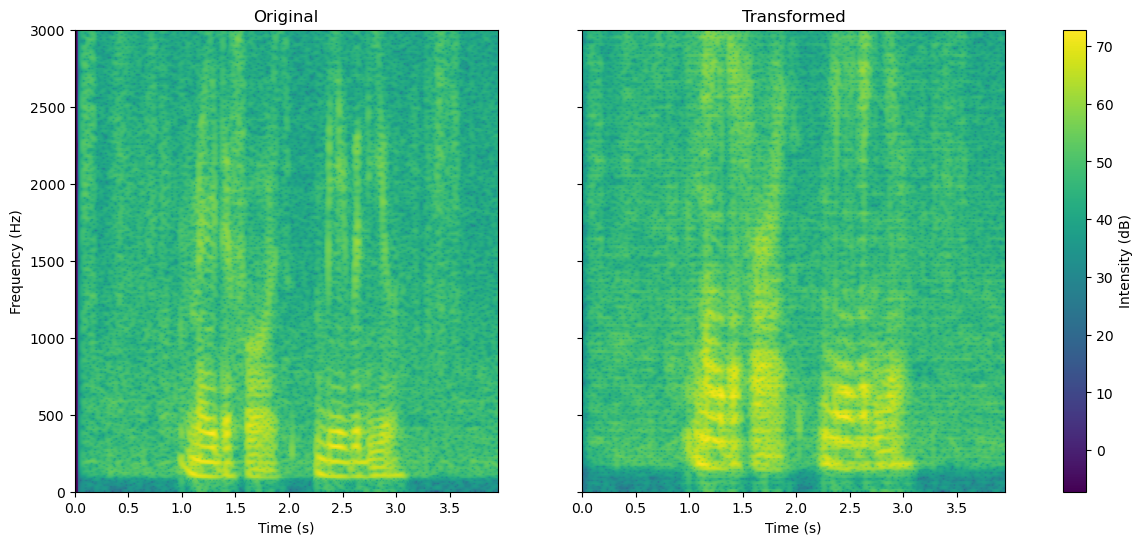

In [51]:
# Load original and transformed audio
file_original = 'Audios/Person2.wav'
file_transformed = 'Audios/Person2_VoiceChanged.wav'

audios = [file_original, file_transformed]
titles = ['Original', 'Transformed']

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for i, file_path in enumerate(audios):
    fs, data = wavfile.read(file_path)
    if len(data.shape) > 1: 
        data = data[:, 0]
    
    win_size = int(0.1 * fs)
    step = win_size // 50
    
    freqs, spec = gabor_wft(data, fs, win_size, step) 
    
    spec_db = 10 * np.log10(spec + 1e-10)
    
    # Visualization
    vmax = np.max(spec_db)
    vmin = vmax - 80 
    
    im = axes[i].imshow(spec_db, aspect='auto', origin='lower', extent=[0, len(data)/fs, 0, fs/2], vmin=vmin, vmax=vmax, cmap='viridis')
    
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylim(0, 3000) 

axes[0].set_ylabel('Frequency (Hz)')
plt.colorbar(im, ax=axes, label='Intensity (dB)')
plt.show()